In [367]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
import time
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

In [368]:
from tqdm.autonotebook import tqdm
tqdm.pandas()

In [369]:
def openCSV(filename):
    '''
    Takes in filename string (with position relative to this location)
    Returns dataframe
    '''
    file = pd.read_csv(filename)
    return pd.DataFrame(file)

In [370]:
# Open all the files
dos_df = openCSV("./DoS_dataset.csv")
fuzzy_df = openCSV("./Fuzzy_dataset.csv")
gear_df = openCSV("./gear_dataset.csv")
rpm_df = openCSV("./RPM_dataset.csv")

# DOS
1. Reformat the data to combine the data payload and to equalize the 8bit and 2bit data
2. Encode to matrix of binary
3. Apply KNN

In [371]:
dos_df.head()

,1478198376.389427,0316,8,05,21,68,09,21.1,21.2,00,6f,R
0,1.478198e+09,018f,8,fe,5b,00,00,00,3c,00,00,R
1,1.478198e+09,0260,8,19,21,22,30,08,8e,6d,3a,R
2,1.478198e+09,02a0,8,64,00,9a,1d,97,02,bd,00,R
3,1.478198e+09,0329,8,40,bb,7f,14,11,20,00,14,R
4,1.478198e+09,0545,8,d8,00,00,8a,00,00,00,00,R


In [372]:
# Add label to the data
dos_df.columns = ["Timestamp","CAN ID","Data size (bytes)","[P","a","Y","L","O","A","D","data]","Label"]
dos_df.head()

,Timestamp,CAN ID,Data size (bytes),[P,a,Y,L,O,A,D,data],Label
0,1.478198e+09,018f,8,fe,5b,00,00,00,3c,00,00,R
1,1.478198e+09,0260,8,19,21,22,30,08,8e,6d,3a,R
2,1.478198e+09,02a0,8,64,00,9a,1d,97,02,bd,00,R
3,1.478198e+09,0329,8,40,bb,7f,14,11,20,00,14,R
4,1.478198e+09,0545,8,d8,00,00,8a,00,00,00,00,R


In [373]:
# Splitting the 2 bytes and 8 bytes data
twob_dos_df = dos_df[dos_df["Label"].isnull()]
eightb_dos_df = dos_df[dos_df["Label"].isnull()  == False]

In [374]:
# Combine payload
eightb_dos_df["data"] = eightb_dos_df['[P'] + eightb_dos_df["a"] + eightb_dos_df["Y"] + eightb_dos_df["L"]  + eightb_dos_df["O"]  + eightb_dos_df["A"]  + eightb_dos_df["D"]  + eightb_dos_df["data]"]
eightb_dos_df.head()

/Users/nanatan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Timestamp,CAN ID,Data size (bytes),[P,a,Y,L,O,A,D,data],Label,data
0,1.478198e+09,018f,8,fe,5b,00,00,00,3c,00,00,R,fe5b0000003c0000
1,1.478198e+09,0260,8,19,21,22,30,08,8e,6d,3a,R,19212230088e6d3a
2,1.478198e+09,02a0,8,64,00,9a,1d,97,02,bd,00,R,64009a1d9702bd00
3,1.478198e+09,0329,8,40,bb,7f,14,11,20,00,14,R,40bb7f1411200014
4,1.478198e+09,0545,8,d8,00,00,8a,00,00,00,00,R,d800008a00000000


In [375]:
# Clean up unused columns
eightb_dos_df = eightb_dos_df.drop(columns=['[P',"a","Y","L","O","A","D","data]"])
eightb_dos_df.head()

,Timestamp,CAN ID,Data size (bytes),Label,data
0,1.478198e+09,018f,8,R,fe5b0000003c0000
1,1.478198e+09,0260,8,R,19212230088e6d3a
2,1.478198e+09,02a0,8,R,64009a1d9702bd00
3,1.478198e+09,0329,8,R,40bb7f1411200014
4,1.478198e+09,0545,8,R,d800008a00000000


In [376]:
# Label and clean up the 2 bytes entries
twob_dos_df = twob_dos_df.dropna(axis='columns')
twob_dos_df.columns = ["Timestamp","CAN ID","Data size (bytes)","[Payload","Data]","Label"]
twob_dos_df.head()

,Timestamp,CAN ID,Data size (bytes),[Payload,Data],Label
35,1.478198e+09,05f0,2,01,00,R
134,1.478198e+09,05f0,2,01,00,R
226,1.478198e+09,05f0,2,01,00,R
319,1.478198e+09,05f0,2,01,00,R
411,1.478198e+09,05f0,2,01,00,R


In [377]:
# Combine payload for 2 bytes entries
twob_dos_df["data"] = twob_dos_df['[Payload'] + twob_dos_df["Data]"]
twob_dos_df.head()

,Timestamp,CAN ID,Data size (bytes),[Payload,Data],Label,data
35,1.478198e+09,05f0,2,01,00,R,0100
134,1.478198e+09,05f0,2,01,00,R,0100
226,1.478198e+09,05f0,2,01,00,R,0100
319,1.478198e+09,05f0,2,01,00,R,0100
411,1.478198e+09,05f0,2,01,00,R,0100


In [378]:
# Clean up unused label 
twob_dos_df = twob_dos_df.drop(columns=['[Payload',"Data]"])
twob_dos_df.head()

,Timestamp,CAN ID,Data size (bytes),Label,data
35,1.478198e+09,05f0,2,R,0100
134,1.478198e+09,05f0,2,R,0100
226,1.478198e+09,05f0,2,R,0100
319,1.478198e+09,05f0,2,R,0100
411,1.478198e+09,05f0,2,R,0100


In [379]:
# Combine the 8bytes and 2bytes entries together
frames = [eightb_dos_df,twob_dos_df]
dos_formatted = pd.concat(frames)

In [380]:
dos_formatted.head()

,Timestamp,CAN ID,Data size (bytes),Label,data
0,1.478198e+09,018f,8,R,fe5b0000003c0000
1,1.478198e+09,0260,8,R,19212230088e6d3a
2,1.478198e+09,02a0,8,R,64009a1d9702bd00
3,1.478198e+09,0329,8,R,40bb7f1411200014
4,1.478198e+09,0545,8,R,d800008a00000000


In [381]:
# Return dataframe to the same order as original based on timestamp
dos_formatted = dos_formatted.sort_values(by=['Timestamp'])
dos_formatted.tail()

,Timestamp,CAN ID,Data size (bytes),Label,data
3665765,1.478201e+09,018f,8,R,fe59000000410000
3665766,1.478201e+09,0260,8,R,18212130088f6d19
3665767,1.478201e+09,02a0,8,R,24009a1d9702bd00
3665768,1.478201e+09,0329,8,R,dcb77f1411200014
3665769,1.478201e+09,0545,8,R,d800008b00000000


# Until here has been reformatting and combining the 2 bytes and 8 bytes data. 

In [382]:
# Convert CAN ID to int representation
dos_formatted['CAN ID'] = [int(x,16) for x in dos_formatted['CAN ID']]
dos_formatted.head()


,Timestamp,CAN ID,Data size (bytes),Label,data
0,1.478198e+09,399,8,R,fe5b0000003c0000
1,1.478198e+09,608,8,R,19212230088e6d3a
2,1.478198e+09,672,8,R,64009a1d9702bd00
3,1.478198e+09,809,8,R,40bb7f1411200014
4,1.478198e+09,1349,8,R,d800008a00000000


In [383]:
# Let's only take 5000 sample
dos_formatted_5k = dos_formatted[:10000]

In [384]:
class MsgData:
    def __init__(self,can_id,time,index):
        self.can_id = can_id
        self.last_occured = time
        self.last_index = index
    
    def updateTime(self,time):
        self.last_occured = time
        
    def updateIndex(self,index):
        self.last_index = index 
        
    def getTimeDiff(self,time):
        return time - self.last_occured
    
    def getIndex(self):
        return self.last_index

In [385]:
'''
id: xxxx
last_occured: <time>
data: []
data_count = x

keep last occured index rather than data
then it can look for the data itself later on
'''
hashtable = {}
time_series = []
data_series = []
data_len_series = []

for index, row in dos_formatted_5k.iterrows():
    if row['CAN ID'] not in hashtable:
        hashtable[row['CAN ID']] = MsgData(row['CAN ID'],row['Timestamp'],index)
    #get the time difference
    time_series.append(hashtable[row['CAN ID']].getTimeDiff(row['Timestamp']))
    #write down the data in between
#     print("get data from index",hashtable[row['CAN ID']].getIndex()," to index",index)
    data_inbetween = dos_formatted_5k.loc[np.r_[hashtable[row['CAN ID']].getIndex()+1:index]]['CAN ID'].values
    data_series.append(data_inbetween)
    #might as well do the length
    data_len_series.append(len(data_inbetween))
    #update everything
    hashtable[row['CAN ID']].updateTime(row['Timestamp'])
    hashtable[row['CAN ID']].updateIndex(index)
    hashtable[row['CAN ID']].updateTime(row['Timestamp'])
    

In [386]:
print(len(time_series))
print(len(data_series))
print(len(data_len_series))

10000
10000
10000


In [387]:
data_series[1]

array([], dtype=int64)

In [388]:
dos_formatted_5k["Time since"] = time_series
dos_formatted_5k["Data in between"] = data_series
dos_formatted_5k["How many data since last"] = data_len_series

/Users/nanatan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/nanatan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/nanatan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

In [389]:
dos_formatted_5k.head(20)
#How many since last = how many data is between the 2 occurence.

,Timestamp,CAN ID,Data size (bytes),Label,data,Time since,Data in between,How many data since last
0,1.478198e+09,399,8,R,fe5b0000003c0000,0.000000,[],0
1,1.478198e+09,608,8,R,19212230088e6d3a,0.000000,[],0
2,1.478198e+09,672,8,R,64009a1d9702bd00,0.000000,[],0
3,1.478198e+09,809,8,R,40bb7f1411200014,0.000000,[],0
4,1.478198e+09,1349,8,R,d800008a00000000,0.000000,[],0
5,1.478198e+09,2,8,R,0000000000030b11,0.000000,[],0
6,1.478198e+09,339,8,R,002110ff00ff0000,0.000000,[],0
7,1.478198e+09,704,8,R,1400000000000000,0.000000,[],0
8,1.478198e+09,304,8,R,088000ff31800b7f,0.000000,[],0
9,1.478198e+09,305,8,R,e57f0000487f0bac,0.000000,[],0


In [390]:
# Randomize to break locality and then split data to 70:30 
train, test = np.split(dos_formatted_5k.sample(frac=1), [int(.7*len(dos_formatted_5k))])
train.head()

,Timestamp,CAN ID,Data size (bytes),Label,data,Time since,Data in between,How many data since last
6227,1.478198e+09,0,8,T,0000000000000000,0.000549,[2],1
1755,1.478198e+09,790,8,R,052168092121006f,0.069982,"[0, 399, 1072, 0, 704, 0, 1201, 0, 497, 0, 339...",58
3921,1.478198e+09,399,8,R,fe5b0000003c0000,0.019981,"[0, 608, 0, 672, 0, 790, 0, 809, 0, 1087, 0, 1...",27
7133,1.478198e+09,1349,8,R,d800008a00000000,0.010391,"[0, 0, 0, 0, 1072, 0, 848, 0, 1201, 0, 497, 0,...",40
1975,1.478198e+09,1072,8,R,0000000000000000,0.020676,"[0, 704, 0, 1201, 0, 497, 0, 339, 0, 2, 0, 848...",72


In [391]:
print(train.shape)
print(test.shape)

(7000, 8)
(3000, 8)


In [392]:
def createIntLabel(df):
    '''
    Input is df
    Output 0/1 version of the label
    '''
    int_label = []
    for x in df['Label']:
        if x == True:
            int_label.append(1)
        else:
            int_label.append(0)
    return int_label

In [393]:
def binary(x):
    if x == "T":
        return 1
    return 0

In [394]:
# Prepare data for 
train_label = [binary(x) for x in train['Label']]
train_data = train.drop(columns="Label")
test_label = [binary(x) for x in test['Label']]
test_data = test.drop(columns="Label")

In [395]:
#Ok what if, we just focus, on CAN-ID, and data, nothing else
simplified_train_data = train_data.drop(columns=["Timestamp","Data size (bytes)","Data in between","How many data since last","data"])
simplified_train_data = simplified_train_data.set_index("CAN ID")
simplified_train_data.head()

,Time since
CAN ID,
0,0.000549
790,0.069982
399,0.019981
1349,0.010391
1072,0.020676


In [396]:
simplified_test_data = test_data.drop(columns=["Timestamp","Data size (bytes)","Data in between","How many data since last","data"])
simplified_test_data = simplified_test_data.set_index("CAN ID")
simplified_test_data.head()

,Time since
CAN ID,
0,0.000492
880,0.009791
672,0.030412
1087,0.005818
0,0.005409


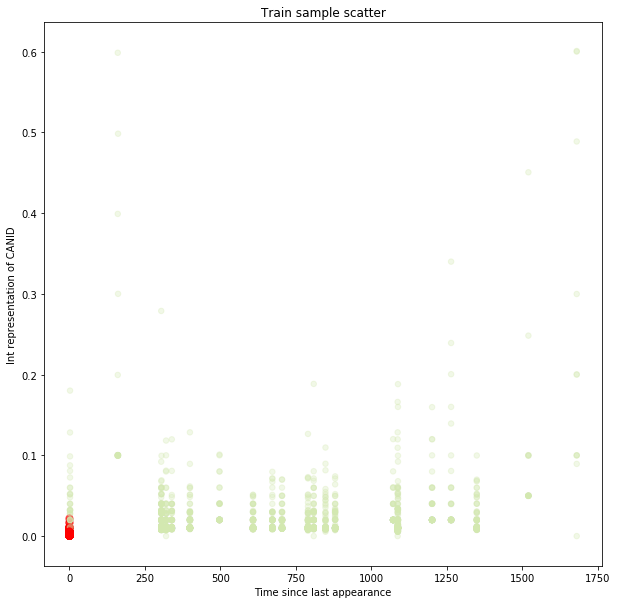

In [397]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(10,10))
c = []
s = []
for x in test_label:
    if x == 1:
        c.append("red")
        s.append(50)
    else:
        c.append("#D3E8B0")
        s.append(30)
plt.scatter(simplified_test_data.index,simplified_test_data["Time since"],alpha=0.3,c=c,s=s)
plt.title('Train sample scatter')
plt.xlabel('Time since last appearance')
plt.ylabel('Int representation of CANID')
plt.show()

In [398]:
simplified_train_data.shape
len(train_label)

7000

In [399]:
def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
            TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
            FP += 1
        if y_actual[i]==y_hat[i]==0:
            TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
            FN += 1
    return(TP, FP, TN, FN)

In [400]:
#Let's try...KNN (it should be able to detect DOS)
classifier = KNeighborsClassifier(n_neighbors = 5)
classifier.fit(simplified_train_data,train_label)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [401]:
guesses = classifier.predict(simplified_test_data)
guesses

array([1, 0, 0, ..., 1, 0, 1])

In [402]:
classifier.score(simplified_test_data,test_label)

0.9883333333333333

In [403]:
print("Accuracy:",accuracy_score(test_label,guesses))
print("Recall:",recall_score(test_label,guesses))
print("Precision:",precision_score(test_label,guesses))
print("F1:",f1_score(test_label,guesses))
print("TP, FP, TN, FN\n",perf_measure(test_label,guesses))

Accuracy: 0.9883333333333333
Recall: 0.9754170324846356
Precision: 0.9937388193202147
F1: 0.9844926894107221
TP, FP, TN, FN
 (1111, 7, 1854, 28)


In [404]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)
clf.fit(simplified_train_data, train_label)

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(5, 2), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [405]:
guesses = clf.predict(simplified_test_data)
guesses

array([1, 0, 0, ..., 1, 0, 1])

In [406]:
print("Accuracy:",accuracy_score(test_label,guesses))
print("Recall:",recall_score(test_label,guesses))
print("Precision:",precision_score(test_label,guesses))
print("F1:",f1_score(test_label,guesses))
print("TP, FP, TN, FN\n",perf_measure(test_label,guesses))

Accuracy: 0.986
Recall: 0.9701492537313433
Precision: 0.9928122192273136
F1: 0.9813499111900533
TP, FP, TN, FN
 (1105, 8, 1853, 34)


In [407]:
from sklearn.svm import SVC
classifier = SVC(kernel='linear')
classifier.fit(simplified_train_data,train_label)
guesses = classifier.predict(simplified_test_data)
print("Accuracy:",accuracy_score(test_label,guesses))
print("Recall:",recall_score(test_label,guesses))
print("Precision:",precision_score(test_label,guesses))
print("F1:",f1_score(test_label,guesses))
print("TP, FP, TN, FN\n",perf_measure(test_label,guesses))

Accuracy: 0.6203333333333333
Recall: 0.0
Precision: 0.0
F1: 0.0
TP, FP, TN, FN
 (0, 0, 1861, 1139)


/Users/nanatan/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/nanatan/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [408]:
#TP, FP, TN, FN
perf_measure(test_label,guesses)

(0, 0, 1861, 1139)

In [409]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier()
classifier.fit(simplified_train_data,train_label)
guesses = classifier.predict(simplified_test_data)
print("Accuracy:",accuracy_score(test_label,guesses))
print("Recall:",recall_score(test_label,guesses))
print("Precision:",precision_score(test_label,guesses))
print("F1:",f1_score(test_label,guesses))
print("TP, FP, TN, FN\n",perf_measure(test_label,guesses))

Accuracy: 0.984
Recall: 0.9736611062335382
Precision: 0.9840283939662822
F1: 0.9788172992056487
TP, FP, TN, FN
 (1109, 18, 1843, 30)


In [410]:
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(simplified_train_data,train_label)
guesses = classifier.predict(simplified_test_data)
print("Accuracy:",accuracy_score(test_label,guesses))
print("Recall:",recall_score(test_label,guesses))
print("Precision:",precision_score(test_label,guesses))
print("F1:",f1_score(test_label,guesses))
print("TP, FP, TN, FN\n",perf_measure(test_label,guesses))

Accuracy: 0.9773333333333334
Recall: 0.974539069359087
Precision: 0.9660574412532638
F1: 0.9702797202797202
TP, FP, TN, FN
 (1110, 39, 1822, 29)


The overall goal is to detect mixed
1. Does order make a difference (does randomizing and non randomizing it affect anything?) - very negligible effect 
2. Try a data trained on DOS on different dataset? It should fare badly 
3. Other sensei did SVM and random forest on individual set as well...we can look into MLP for deep learning intro.

In [411]:
#If keeping it ordered
train, test = np.split(dos_formatted_5k, [int(.7*len(dos_formatted_5k))])
train.head()


,Timestamp,CAN ID,Data size (bytes),Label,data,Time since,Data in between,How many data since last
0,1.478198e+09,399,8,R,fe5b0000003c0000,0.0,[],0
1,1.478198e+09,608,8,R,19212230088e6d3a,0.0,[],0
2,1.478198e+09,672,8,R,64009a1d9702bd00,0.0,[],0
3,1.478198e+09,809,8,R,40bb7f1411200014,0.0,[],0
4,1.478198e+09,1349,8,R,d800008a00000000,0.0,[],0


# CLEAN ALL THE OTHER data

## Gear data cleaning

In [412]:
# Add label to the data
gear_df.columns = ["Timestamp","CAN ID","Data size (bytes)","[P","a","Y","L","O","A","D","data]","Label"]
# Splitting the 2 bytes and 8 bytes data
twob_gear_df = gear_df[gear_df["Label"].isnull()]
eightb_gear_df = gear_df[gear_df["Label"].isnull()  == False]
# Combine payload
eightb_gear_df["data"] = eightb_gear_df['[P'] + eightb_gear_df["a"] + eightb_gear_df["Y"] + eightb_gear_df["L"]  + eightb_gear_df["O"]  + eightb_gear_df["A"]  + eightb_gear_df["D"]  + eightb_gear_df["data]"]
eightb_gear_df = eightb_gear_df.drop(columns=['[P',"a","Y","L","O","A","D","data]"])
twob_gear_df = twob_gear_df.dropna(axis='columns')
twob_gear_df.columns = ["Timestamp","CAN ID","Data size (bytes)","[Payload","Data]","Label"]
# Combine payload for 2 bytes entries
twob_gear_df["data"] = twob_gear_df['[Payload'] + twob_gear_df["Data]"]
twob_gear_df = twob_gear_df.drop(columns=['[Payload',"Data]"])
frames = [eightb_gear_df,twob_gear_df]
gear_formatted = pd.concat(frames)
# Return dataframe to the same order as original based on timestamp
gear_formatted = gear_formatted.sort_values(by=['Timestamp'])

/Users/nanatan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [413]:
gear_formatted[gear_formatted["Data size (bytes)"] == 2].head()

,Timestamp,CAN ID,Data size (bytes),Label,data
52,1.478193e+09,05f0,2,R,0100
144,1.478193e+09,05f0,2,R,0100
237,1.478193e+09,05f0,2,R,0100
329,1.478193e+09,05f0,2,R,0100
422,1.478193e+09,05f0,2,R,0100


In [414]:
# Convert CAN ID to int representation
gear_formatted['CAN ID'] = [int(x,16) for x in gear_formatted['CAN ID']]
# Let's only take 5000 sample
gear_formatted_5k = gear_formatted[:10000]
hashtable = {}
time_series = []
data_series = []
data_len_series = []
for index, row in gear_formatted_5k.iterrows():
    if row['CAN ID'] not in hashtable:
        hashtable[row['CAN ID']] = MsgData(row['CAN ID'],row['Timestamp'],index)
    #get the time difference
    time_series.append(hashtable[row['CAN ID']].getTimeDiff(row['Timestamp']))
    #write down the data in between
#     print("get data from index",hashtable[row['CAN ID']].getIndex()," to index",index)
    data_inbetween = gear_formatted_5k.loc[np.r_[hashtable[row['CAN ID']].getIndex()+1:index]]['CAN ID'].values
    data_series.append(data_inbetween)
    #might as well do the length
    data_len_series.append(len(data_inbetween))
    #update everything
    hashtable[row['CAN ID']].updateTime(row['Timestamp'])
    hashtable[row['CAN ID']].updateIndex(index)
    hashtable[row['CAN ID']].updateTime(row['Timestamp'])
gear_formatted_5k["Time since"] = time_series
gear_formatted_5k["Data in between"] = data_series
gear_formatted_5k["How many data since last"] = data_len_series
gear_train, gear_test = np.split(gear_formatted_5k.sample(frac=1), [int(.7*len(gear_formatted_5k))])
# Prepare data for 
gear_train_label = [binary(x) for x in gear_train['Label']]
gear_train_data = gear_train.drop(columns="Label")
gear_test_label = [binary(x) for x in gear_test['Label']]
gear_test_data = gear_test.drop(columns="Label")
#Ok what if, we just focus, on CAN-ID, and data, nothing else
simplified_gear_train_data = gear_train_data.drop(columns=["Timestamp","Data size (bytes)","Data in between","How many data since last","data"])
simplified_gear_train_data = simplified_gear_train_data.set_index("CAN ID")
simplified_gear_test_data = gear_test_data.drop(columns=["Timestamp","Data size (bytes)","Data in between","How many data since last","data"])
simplified_gear_test_data = simplified_gear_test_data.set_index("CAN ID")

/Users/nanatan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/nanatan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/nanatan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-do

In [415]:
#Let's try...KNN 
classifier = KNeighborsClassifier(n_neighbors = 5)
classifier.fit(simplified_gear_train_data,gear_train_label)
guesses = classifier.predict(simplified_gear_test_data)
classifier.score(simplified_gear_test_data,test_label)
print("Accuracy:",accuracy_score(gear_test_label,guesses))
print("Recall:",recall_score(gear_test_label,guesses))
print("Precision:",precision_score(gear_test_label,guesses))
print("F1:",f1_score(gear_test_label,guesses))
print("TP, FP, TN, FN\n",perf_measure(gear_test_label,guesses))

Accuracy: 0.981
Recall: 0.9626016260162602
Precision: 0.9456869009584664
F1: 0.9540692989524577
TP, FP, TN, FN
 (592, 34, 2351, 23)


In [416]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(random_state=1, max_iter=300)
clf.fit(simplified_gear_train_data, gear_train_label)
guesses = clf.predict(simplified_gear_test_data)
print("Accuracy:",accuracy_score(gear_test_label,guesses))
print("Recall:",recall_score(gear_test_label,guesses))
print("Precision:",precision_score(gear_test_label,guesses))
print("F1:",f1_score(gear_test_label,guesses))
print("TP, FP, TN, FN\n",perf_measure(gear_test_label,guesses))

Accuracy: 0.961
Recall: 0.9300813008130081
Precision: 0.8854489164086687
F1: 0.9072164948453607
TP, FP, TN, FN
 (572, 74, 2311, 43)


In [417]:
from sklearn.svm import SVC
classifier = SVC(kernel='linear')
classifier.fit(simplified_gear_train_data,gear_train_label)
guesses = classifier.predict(simplified_gear_test_data)
guesses

array([0, 0, 0, ..., 0, 0, 0])

In [418]:
classifier.score(simplified_gear_test_data,test_label)
print("Accuracy:",accuracy_score(gear_test_label,guesses))
print("Recall:",recall_score(gear_test_label,guesses))
print("Precision:",precision_score(gear_test_label,guesses))
print("F1:",f1_score(gear_test_label,guesses))
print("TP, FP, TN, FN\n",perf_measure(gear_test_label,guesses))

Accuracy: 0.795
Recall: 0.0
Precision: 0.0
F1: 0.0
TP, FP, TN, FN
 (0, 0, 2385, 615)


/Users/nanatan/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/nanatan/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [419]:
#TP, FP, TN, FN
perf_measure(gear_test_label,guesses)

(0, 0, 2385, 615)

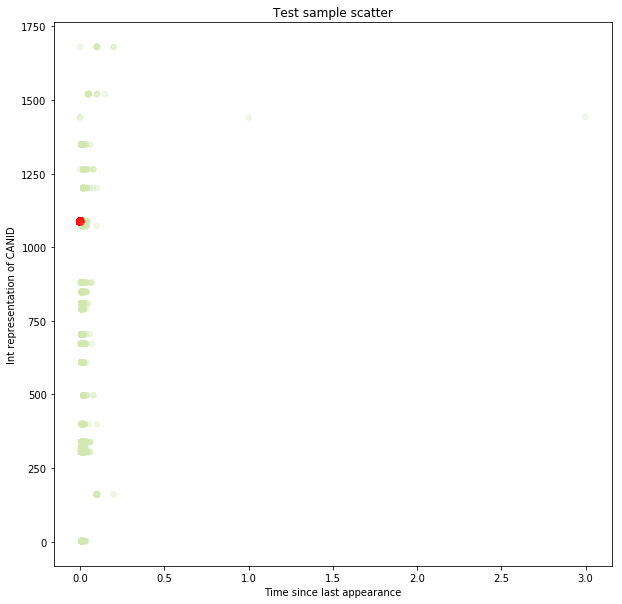

In [420]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(10,10))
c = []
s = []
for x in gear_test_label:
    if x == 1:
        c.append("red")
        s.append(50)
    else:
        c.append("#D3E8B0")
        s.append(30)
plt.scatter(simplified_gear_test_data["Time since"],simplified_gear_test_data.index,alpha=0.3,c=c,s=s)
plt.title('Test sample scatter')
plt.xlabel('Time since last appearance')
plt.ylabel('Int representation of CANID')
plt.show()

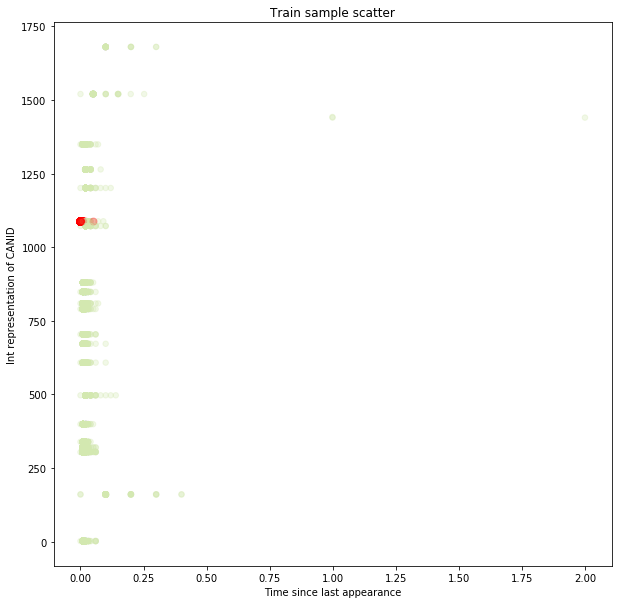

In [421]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(10,10))
c = []
s = []
for x in gear_train_label:
    if x == 1:
        c.append("red")
        s.append(50)
    else:
        c.append("#D3E8B0")
        s.append(30)
plt.scatter(simplified_gear_train_data["Time since"],simplified_gear_train_data.index,alpha=0.3,c=c,s=s)
plt.title('Train sample scatter')
plt.xlabel('Time since last appearance')
plt.ylabel('Int representation of CANID')
plt.show()

In [422]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier()
classifier.fit(simplified_gear_train_data,gear_train_label)
guesses = classifier.predict(simplified_gear_test_data)
classifier.score(simplified_gear_test_data,test_label)
print("Accuracy:",accuracy_score(gear_test_label,guesses))
print("Recall:",recall_score(gear_test_label,guesses))
print("Precision:",precision_score(gear_test_label,guesses))
print("F1:",f1_score(gear_test_label,guesses))
print("TP, FP, TN, FN\n",perf_measure(gear_test_label,guesses))

Accuracy: 0.969
Recall: 0.9284552845528455
Precision: 0.9209677419354839
F1: 0.9246963562753036
TP, FP, TN, FN
 (571, 49, 2336, 44)


In [423]:
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(simplified_gear_train_data,gear_train_label)
guesses = classifier.predict(simplified_gear_test_data)
classifier.score(simplified_gear_test_data,test_label)
print("Accuracy:",accuracy_score(gear_test_label,guesses))
print("Recall:",recall_score(gear_test_label,guesses))
print("Precision:",precision_score(gear_test_label,guesses))
print("F1:",f1_score(gear_test_label,guesses))
print("TP, FP, TN, FN\n",perf_measure(gear_test_label,guesses))

Accuracy: 0.9666666666666667
Recall: 0.959349593495935
Precision: 0.8872180451127819
F1: 0.9218749999999999
TP, FP, TN, FN
 (590, 75, 2310, 25)


## RPM data cleaning

In [424]:
# Add label to the data
rpm_df.columns = ["Timestamp","CAN ID","Data size (bytes)","[P","a","Y","L","O","A","D","data]","Label"]
# Splitting the 2 bytes and 8 bytes data
twob_rpm_df = rpm_df[rpm_df["Label"].isnull()]
eightb_rpm_df = rpm_df[rpm_df["Label"].isnull()  == False]
# Combine payload
eightb_rpm_df["data"] = eightb_rpm_df['[P'] + eightb_rpm_df["a"] + eightb_rpm_df["Y"] + eightb_rpm_df["L"]  + eightb_rpm_df["O"]  + eightb_rpm_df["A"]  + eightb_rpm_df["D"]  + eightb_rpm_df["data]"]
eightb_rpm_df = eightb_rpm_df.drop(columns=['[P',"a","Y","L","O","A","D","data]"])
twob_rpm_df = twob_rpm_df.dropna(axis='columns')
twob_rpm_df.columns = ["Timestamp","CAN ID","Data size (bytes)","[Payload","Data]","Label"]
# Combine payload for 2 bytes entries
twob_rpm_df["data"] = twob_rpm_df['[Payload'] + twob_rpm_df["Data]"]
twob_rpm_df = twob_rpm_df.drop(columns=['[Payload',"Data]"])
frames = [eightb_rpm_df,twob_rpm_df]
rpm_formatted = pd.concat(frames)
# Return dataframe to the same order as original based on timestamp
rpm_formatted = rpm_formatted.sort_values(by=['Timestamp'])

/Users/nanatan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [425]:
rpm_formatted[rpm_formatted["Data size (bytes)"] == 2].head()

,Timestamp,CAN ID,Data size (bytes),Label,data
42,1.478191e+09,05f0,2,R,0100
134,1.478191e+09,05f0,2,R,0100
227,1.478191e+09,05f0,2,R,0100
319,1.478191e+09,05f0,2,R,0100
412,1.478191e+09,05f0,2,R,0100


In [426]:
# Convert CAN ID to int representation
rpm_formatted['CAN ID'] = [int(x,16) for x in rpm_formatted['CAN ID']]
# Let's only take 5000 sample
rpm_formatted_5k = rpm_formatted[:10000]
hashtable = {}
time_series = []
data_series = []
data_len_series = []
for index, row in rpm_formatted_5k.iterrows():
    if row['CAN ID'] not in hashtable:
        hashtable[row['CAN ID']] = MsgData(row['CAN ID'],row['Timestamp'],index)
    #get the time difference
    time_series.append(hashtable[row['CAN ID']].getTimeDiff(row['Timestamp']))
    #write down the data in between
#     print("get data from index",hashtable[row['CAN ID']].getIndex()," to index",index)
    data_inbetween = rpm_formatted_5k.loc[np.r_[hashtable[row['CAN ID']].getIndex()+1:index]]['CAN ID'].values
    data_series.append(data_inbetween)
    #might as well do the length
    data_len_series.append(len(data_inbetween))
    #update everything
    hashtable[row['CAN ID']].updateTime(row['Timestamp'])
    hashtable[row['CAN ID']].updateIndex(index)
    hashtable[row['CAN ID']].updateTime(row['Timestamp'])
rpm_formatted_5k["Time since"] = time_series
rpm_formatted_5k["Data in between"] = data_series
rpm_formatted_5k["How many data since last"] = data_len_series
rpm_train, rpm_test = np.split(rpm_formatted_5k.sample(frac=1), [int(.7*len(gear_formatted_5k))])


/Users/nanatan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/nanatan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/nanatan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-do

In [427]:
rpm_test[rpm_test["Label"] == "T"].head()

,Timestamp,CAN ID,Data size (bytes),Label,data,Time since,Data in between,How many data since last
7954,1.478191e+09,790,8,T,452924ff292400ff,0.001117,[],0
1743,1.478191e+09,790,8,T,452924ff292400ff,0.001144,[],0
5199,1.478191e+09,790,8,T,452924ff292400ff,0.001120,[],0
8629,1.478191e+09,790,8,T,452924ff292400ff,0.001132,[],0
7013,1.478191e+09,790,8,T,452924ff292400ff,0.000958,"[1087, 1088, 1349]",3


In [428]:
# Prepare data for 
rpm_train_label = [binary(x) for x in rpm_train['Label']]
rpm_train_data = rpm_train.drop(columns="Label")
rpm_test_label = [binary(x) for x in rpm_test['Label']]
rpm_test_data = rpm_test.drop(columns="Label")
#Ok what if, we just focus, on CAN-ID, and data, nothing else
simplified_rpm_train_data = rpm_train_data.drop(columns=["Timestamp","Data size (bytes)","Data in between","How many data since last","data"])
simplified_rpm_train_data = simplified_rpm_train_data.set_index("CAN ID")
simplified_rpm_test_data = rpm_test_data.drop(columns=["Timestamp","Data size (bytes)","Data in between","How many data since last","data"])
simplified_rpm_test_data = simplified_rpm_test_data.set_index("CAN ID")

In [429]:
simplified_rpm_test_data.head()

,Time since
CAN ID,
1264,0.020160
1088,0.010437
790,0.000236
672,0.009555
339,0.009013


In [430]:
#Let's try...KNN 
classifier = KNeighborsClassifier(n_neighbors = 5)
classifier.fit(simplified_rpm_train_data,rpm_train_label)
guesses = classifier.predict(simplified_rpm_test_data)
classifier.score(simplified_rpm_test_data,rpm_test_label)
print("Accuracy:",accuracy_score(rpm_test_label,guesses))
print("Recall:",recall_score(rpm_test_label,guesses))
print("Precision:",precision_score(rpm_test_label,guesses))
print("F1:",f1_score(rpm_test_label,guesses))
print("TP, FP, TN, FN\n",perf_measure(rpm_test_label,guesses))

Accuracy: 0.9853333333333333
Recall: 0.9714673913043478
Precision: 0.9688346883468835
F1: 0.9701492537313432
TP, FP, TN, FN
 (715, 23, 2241, 21)


In [431]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(random_state=1, max_iter=300)
clf.fit(simplified_rpm_train_data,rpm_train_label)
guesses = clf.predict(simplified_rpm_test_data)
clf.score(simplified_rpm_test_data,rpm_test_label)
print("Accuracy:",accuracy_score(rpm_test_label,guesses))
print("Recall:",recall_score(rpm_test_label,guesses))
print("Precision:",precision_score(rpm_test_label,guesses))
print("F1:",f1_score(rpm_test_label,guesses))
print("TP, FP, TN, FN\n",perf_measure(rpm_test_label,guesses))

Accuracy: 0.953
Recall: 0.9456521739130435
Precision: 0.8732747804265998
F1: 0.9080234833659492
TP, FP, TN, FN
 (696, 101, 2163, 40)


In [432]:
from sklearn.svm import SVC
classifier = SVC(kernel='linear')
classifier.fit(simplified_rpm_train_data,rpm_train_label)
guesses = classifier.predict(simplified_rpm_test_data)
classifier.score(simplified_rpm_test_data,rpm_test_label)
print("Accuracy:",accuracy_score(rpm_test_label,guesses))
print("Recall:",recall_score(rpm_test_label,guesses))
print("Precision:",precision_score(rpm_test_label,guesses))
print("F1:",f1_score(rpm_test_label,guesses))
print("TP, FP, TN, FN\n",perf_measure(rpm_test_label,guesses))

Accuracy: 0.7546666666666667
Recall: 0.0
Precision: 0.0
F1: 0.0
TP, FP, TN, FN
 (0, 0, 2264, 736)


/Users/nanatan/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/nanatan/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [433]:
#TP, FP, TN, FN
perf_measure(gear_test_label,guesses)
#the algo thinks everything is fine!

(0, 0, 2385, 615)

In [434]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier()
classifier.fit(simplified_rpm_train_data,rpm_train_label)
guesses = classifier.predict(simplified_rpm_test_data)
classifier.score(simplified_rpm_test_data,rpm_test_label)
print("Accuracy:",accuracy_score(rpm_test_label,guesses))
print("Recall:",recall_score(rpm_test_label,guesses))
print("Precision:",precision_score(rpm_test_label,guesses))
print("F1:",f1_score(rpm_test_label,guesses))
print("TP, FP, TN, FN\n",perf_measure(rpm_test_label,guesses))

Accuracy: 0.98
Recall: 0.9524456521739131
Precision: 0.9655647382920111
F1: 0.9589603283173734
TP, FP, TN, FN
 (701, 25, 2239, 35)


In [435]:
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(simplified_rpm_train_data,rpm_train_label)
guesses = classifier.predict(simplified_rpm_test_data)
classifier.score(simplified_rpm_test_data,rpm_test_label)
print("Accuracy:",accuracy_score(rpm_test_label,guesses))
print("Recall:",recall_score(rpm_test_label,guesses))
print("Precision:",precision_score(rpm_test_label,guesses))
print("F1:",f1_score(rpm_test_label,guesses))
print("TP, FP, TN, FN\n",perf_measure(rpm_test_label,guesses))

Accuracy: 0.9506666666666667
Recall: 0.936141304347826
Precision: 0.8721518987341772
F1: 0.9030144167758847
TP, FP, TN, FN
 (689, 101, 2163, 47)


## Fuzzy data cleaning

In [436]:
# Add label to the data
fuzzy_df.columns = ["Timestamp","CAN ID","Data size (bytes)","[P","a","Y","L","O","A","D","data]","Label"]
# Splitting the 2 bytes and 8 bytes data
twob_fuzzy_df = fuzzy_df[fuzzy_df["Data size (bytes)"] == 2]
fiveb_fuzzy_df = fuzzy_df[fuzzy_df["Data size (bytes)"] == 5]
sixb_fuzzy_df = fuzzy_df[fuzzy_df["Data size (bytes)"] == 6]
eightb_fuzzy_df = fuzzy_df[fuzzy_df["Label"].isnull()  == False]
# Combine payload
eightb_fuzzy_df["data"] = eightb_fuzzy_df['[P'] + eightb_fuzzy_df["a"] + eightb_fuzzy_df["Y"] + eightb_fuzzy_df["L"]  + eightb_fuzzy_df["O"]  + eightb_fuzzy_df["A"]  + eightb_fuzzy_df["D"]  + eightb_fuzzy_df["data]"]
eightb_fuzzy_df = eightb_fuzzy_df.drop(columns=['[P',"a","Y","L","O","A","D","data]"])
twob_fuzzy_df = twob_fuzzy_df.dropna(axis='columns')
twob_fuzzy_df.columns = ["Timestamp","CAN ID","Data size (bytes)","[Payload","Data]","Label"]
fiveb_fuzzy_df["data"] = fiveb_fuzzy_df['[P'] + fiveb_fuzzy_df["a"] + fiveb_fuzzy_df["Y"] + fiveb_fuzzy_df["L"]  + fiveb_fuzzy_df["O"] 
fiveb_fuzzy_df = fiveb_fuzzy_df.drop(columns=['[P',"a","Y","L","O","A","D","data]"])
sixb_fuzzy_df["data"] = sixb_fuzzy_df['[P'] + sixb_fuzzy_df["a"] + sixb_fuzzy_df["Y"] + sixb_fuzzy_df["L"]  + sixb_fuzzy_df["O"]  + sixb_fuzzy_df["A"] 
sixb_fuzzy_df = sixb_fuzzy_df.drop(columns=['[P',"a","Y","L","O","A","D","data]"])
# Combine payload for 2 bytes entries
twob_fuzzy_df["data"] = twob_fuzzy_df['[Payload'] + twob_fuzzy_df["Data]"]
twob_fuzzy_df = twob_fuzzy_df.drop(columns=['[Payload',"Data]"])
frames = [eightb_fuzzy_df,twob_fuzzy_df,fiveb_fuzzy_df,sixb_fuzzy_df]
fuzzy_formatted = pd.concat(frames)
# Return dataframe to the same order as original based on timestamp
fuzzy_formatted = fuzzy_formatted.sort_values(by=['Timestamp'])

/Users/nanatan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/nanatan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/Users/nanatan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

In [437]:
fuzzy_formatted.head()

,Timestamp,CAN ID,Data size (bytes),Label,data
0,1.478196e+09,02b0,5,NaN,ff7f000549
1,1.478196e+09,0002,8,R,0000000000010715
2,1.478196e+09,0153,8,R,002110ff00ff0000
3,1.478196e+09,0130,8,R,198000fffe7f0760
4,1.478196e+09,0131,8,R,17800000657f079f


In [438]:
# Convert CAN ID to int representation
fuzzy_formatted['CAN ID'] = [int(x,16) for x in fuzzy_formatted['CAN ID']]
# Let's only take 5000 sample
fuzzy_formatted_5k = fuzzy_formatted[:10000]
hashtable = {}
time_series = []
data_series = []
data_len_series = []
for index, row in fuzzy_formatted_5k.iterrows():
    if row['CAN ID'] not in hashtable:
        hashtable[row['CAN ID']] = MsgData(row['CAN ID'],row['Timestamp'],index)
    #get the time difference
    time_series.append(hashtable[row['CAN ID']].getTimeDiff(row['Timestamp']))
    #write down the data in between
#     print("get data from index",hashtable[row['CAN ID']].getIndex()," to index",index)
    data_inbetween = fuzzy_formatted_5k.loc[np.r_[hashtable[row['CAN ID']].getIndex()+1:index]]['CAN ID'].values
    data_series.append(data_inbetween)
    #might as well do the length
    data_len_series.append(len(data_inbetween))
    #update everything
    hashtable[row['CAN ID']].updateTime(row['Timestamp'])
    hashtable[row['CAN ID']].updateIndex(index)
    hashtable[row['CAN ID']].updateTime(row['Timestamp'])
fuzzy_formatted_5k["Time since"] = time_series
fuzzy_formatted_5k["Data in between"] = data_series
fuzzy_formatted_5k["How many data since last"] = data_len_series
fuzzy_train, fuzzy_test = np.split(fuzzy_formatted_5k.sample(frac=1), [int(.7*len(gear_formatted_5k))])
# Prepare data for 
fuzzy_train_label = [binary(x) for x in fuzzy_train['Label']]
fuzzy_train_data = fuzzy_train.drop(columns="Label")
fuzzy_test_label = [binary(x) for x in fuzzy_test['Label']]
fuzzy_test_data = fuzzy_test.drop(columns="Label")
#Ok what if, we just focus, on CAN-ID, and data, nothing else
simplified_fuzzy_train_data = fuzzy_train_data.drop(columns=["Timestamp","Data size (bytes)","Data in between","How many data since last","data"])
simplified_fuzzy_train_data = simplified_fuzzy_train_data.set_index("CAN ID")
simplified_fuzzy_test_data = fuzzy_test_data.drop(columns=["Timestamp","Data size (bytes)","Data in between","How many data since last","data"])
simplified_fuzzy_test_data = simplified_fuzzy_test_data.set_index("CAN ID")

/Users/nanatan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/nanatan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/nanatan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-do

In [439]:
#Let's try...KNN 
classifier = KNeighborsClassifier(n_neighbors = 5)
classifier.fit(simplified_fuzzy_train_data,fuzzy_train_label)
guesses = classifier.predict(simplified_fuzzy_test_data)
classifier.score(simplified_fuzzy_test_data,fuzzy_test_label)
print("Accuracy:",accuracy_score(fuzzy_test_label,guesses))
print("Recall:",recall_score(fuzzy_test_label,guesses))
print("Precision:",precision_score(fuzzy_test_label,guesses))
print("F1:",f1_score(fuzzy_test_label,guesses))
print("TP, FP, TN, FN\n",perf_measure(fuzzy_test_label,guesses))

Accuracy: 0.9893333333333333
Recall: 0.9351032448377581
Precision: 0.9694189602446484
F1: 0.9519519519519519
TP, FP, TN, FN
 (317, 10, 2651, 22)


In [440]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(random_state=1, max_iter=300)
clf.fit(simplified_fuzzy_train_data,fuzzy_train_label)
guesses = clf.predict(simplified_fuzzy_test_data)
clf.score(simplified_fuzzy_test_data,fuzzy_test_label)
print("Accuracy:",accuracy_score(fuzzy_test_label,guesses))
print("Recall:",recall_score(fuzzy_test_label,guesses))
print("Precision:",precision_score(fuzzy_test_label,guesses))
print("F1:",f1_score(fuzzy_test_label,guesses))
print("TP, FP, TN, FN\n",perf_measure(fuzzy_test_label,guesses))

Accuracy: 0.904
Recall: 0.15634218289085547
Precision: 0.9636363636363636
F1: 0.26903553299492383
TP, FP, TN, FN
 (53, 2, 2659, 286)


In [441]:
from sklearn.svm import SVC
classifier = SVC(kernel='linear')
classifier.fit(simplified_fuzzy_train_data,fuzzy_train_label)
guesses = classifier.predict(simplified_fuzzy_test_data)
classifier.score(simplified_fuzzy_test_data,fuzzy_test_label)
print("Accuracy:",accuracy_score(fuzzy_test_label,guesses))
print("Recall:",recall_score(fuzzy_test_label,guesses))
print("Precision:",precision_score(fuzzy_test_label,guesses))
print("F1:",f1_score(fuzzy_test_label,guesses))
print("TP, FP, TN, FN\n",perf_measure(fuzzy_test_label,guesses))

Accuracy: 0.9033333333333333
Recall: 0.14454277286135694
Precision: 1.0
F1: 0.2525773195876289
TP, FP, TN, FN
 (49, 0, 2661, 290)


In [442]:
#TP, FP, TN, FN
perf_measure(fuzzy_test_label,guesses)

(49, 0, 2661, 290)

In [443]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier()
classifier.fit(simplified_fuzzy_train_data,fuzzy_train_label)
guesses = classifier.predict(simplified_fuzzy_test_data)
classifier.score(simplified_fuzzy_test_data,fuzzy_test_label)
print("Accuracy:",accuracy_score(fuzzy_test_label,guesses))
print("Recall:",recall_score(fuzzy_test_label,guesses))
print("Precision:",precision_score(fuzzy_test_label,guesses))
print("F1:",f1_score(fuzzy_test_label,guesses))
print("TP, FP, TN, FN\n",perf_measure(fuzzy_test_label,guesses))

Accuracy: 0.9833333333333333
Recall: 0.9410029498525073
Precision: 0.9140401146131805
F1: 0.9273255813953488
TP, FP, TN, FN
 (319, 30, 2631, 20)


In [444]:
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(simplified_fuzzy_train_data,fuzzy_train_label)
guesses = classifier.predict(simplified_fuzzy_test_data)
classifier.score(simplified_fuzzy_test_data,fuzzy_test_label)
print("Accuracy:",accuracy_score(fuzzy_test_label,guesses))
print("Recall:",recall_score(fuzzy_test_label,guesses))
print("Precision:",precision_score(fuzzy_test_label,guesses))
print("F1:",f1_score(fuzzy_test_label,guesses))
print("TP, FP, TN, FN\n",perf_measure(fuzzy_test_label,guesses))

Accuracy: 0.9006666666666666
Recall: 0.19469026548672566
Precision: 0.7252747252747253
F1: 0.3069767441860465
TP, FP, TN, FN
 (66, 25, 2636, 273)


# MIX ALL DATA

In [475]:
dos_mix = dos_formatted[5000:8000]
gear_mix = gear_formatted[5000:8000]
rpm_mix = rpm_formatted[5000:8000]
fuzzy_mix = fuzzy_formatted[3000:6000]

In [502]:
def get_formatted_df(df_input):
    hashtable = {}
    time_series = []
    data_series = []
    data_len_series = []
    for index, row in df_input.iterrows():
        if row['CAN ID'] == 6611:
            print("Hey there's a 6611")
        if row['CAN ID'] not in hashtable:
            hashtable[row['CAN ID']] = MsgData(row['CAN ID'],row['Timestamp'],index)
        #get the time difference
        time_series.append(hashtable[row['CAN ID']].getTimeDiff(row['Timestamp']))
        #write down the data in between
    #     print("get data from index",hashtable[row['CAN ID']].getIndex()," to index",index)
        data_inbetween = df_input.loc[np.r_[hashtable[row['CAN ID']].getIndex()+1:index]]['CAN ID'].values
        data_series.append(data_inbetween)
        #might as well do the length
        data_len_series.append(len(data_inbetween))
        #update everything
        hashtable[row['CAN ID']].updateTime(row['Timestamp'])
        hashtable[row['CAN ID']].updateIndex(index)
        hashtable[row['CAN ID']].updateTime(row['Timestamp'])
    df_input["Time since"] = time_series
    df_input["Data in between"] = data_series
    df_input["How many data since last"] = data_len_series
    return df_input

In [503]:
dos_f_mix = get_formatted_df(dos_mix)
gear_f_mix = get_formatted_df(gear_mix)
rpm_f_mix = get_formatted_df(rpm_mix)
fuzzy_f_mix = get_formatted_df(fuzzy_mix)

df_mix = pd.concat([dos_f_mix,gear_f_mix,rpm_f_mix,fuzzy_f_mix])

/Users/nanatan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/nanatan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/nanatan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-do

In [505]:
df_mix.head()

,Timestamp,CAN ID,Data size (bytes),Label,data,Time since,Data in between,How many data since last
5000,1.478198e+09,790,8,R,05216c092121006f,0.000000,[],0
5001,1.478198e+09,0,8,T,0000000000000000,0.000000,[],0
5002,1.478198e+09,399,8,R,fe5b0000003c0000,0.000000,[],0
5003,1.478198e+09,339,8,R,002110ff00ff0000,0.000000,[],0
5004,1.478198e+09,0,8,T,0000000000000000,0.021903,"[399, 339]",2


In [504]:
idx = 0
for t in df_mix["Time since"]:
    if t < 0:
        print(t)
        print("index",idx)
    idx += 1

In [506]:
mix_train, mix_test = np.split(df_mix.sample(frac=1), [int(.7*len(gear_formatted_5k))])
# Prepare data for 
mix_train_label = [binary(x) for x in mix_train['Label']]
mix_train_data = mix_train.drop(columns="Label")
mix_test_label = [binary(x) for x in mix_test['Label']]
mix_test_data = mix_test.drop(columns="Label")
#Ok what if, we just focus, on CAN-ID, and data, nothing else
simplified_mix_train_data = mix_train_data.drop(columns=["Timestamp","Data size (bytes)","Data in between","How many data since last","data"])
simplified_mix_train_data = simplified_mix_train_data.set_index("CAN ID")
simplified_mix_test_data = mix_test_data.drop(columns=["Timestamp","Data size (bytes)","Data in between","How many data since last","data"])
simplified_mix_test_data = simplified_mix_test_data.set_index("CAN ID")

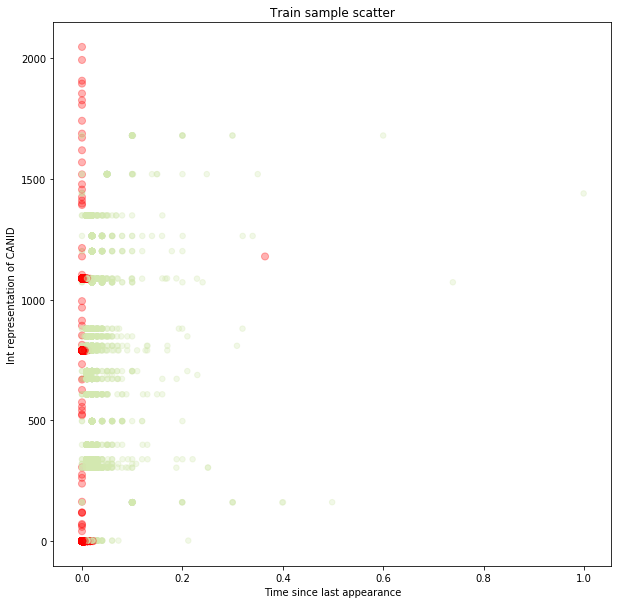

In [507]:
plt.figure(figsize=(10,10))
c = []
s = []
for x in mix_train_label:
    if x == 1:
        c.append("red")
        s.append(50)
    else:
        c.append("#D3E8B0")
        s.append(30)
plt.scatter(simplified_mix_train_data["Time since"],simplified_mix_train_data.index,alpha=0.3,c=c,s=s)
plt.title('Train sample scatter')
plt.xlabel('Time since last appearance')
plt.ylabel('Int representation of CANID')
plt.show()

In [508]:
#Let's try...KNN 
classifier = KNeighborsClassifier(n_neighbors = 5)
classifier.fit(simplified_mix_train_data,mix_train_label)
guesses = classifier.predict(simplified_mix_test_data)
classifier.score(simplified_mix_test_data,mix_test_label)
print("Accuracy:",accuracy_score(mix_test_label,guesses))
print("Recall:",recall_score(mix_test_label,guesses))
print("Precision:",precision_score(mix_test_label,guesses))
print("F1:",f1_score(mix_test_label,guesses))
print("TP, FP, TN, FN\n",perf_measure(mix_test_label,guesses))

Accuracy: 0.9704
Recall: 0.9691895512391159
Precision: 0.934151065203357
F1: 0.9513477975016437
TP, FP, TN, FN
 (1447, 102, 3405, 46)


In [509]:
clf = MLPClassifier(random_state=1, max_iter=300)
clf.fit(simplified_mix_train_data,mix_train_label)
guesses = clf.predict(simplified_mix_test_data)
clf.score(simplified_mix_test_data,mix_test_label)
print("Accuracy:",accuracy_score(mix_test_label,guesses))
print("Recall:",recall_score(mix_test_label,guesses))
print("Precision:",precision_score(mix_test_label,guesses))
print("F1:",f1_score(mix_test_label,guesses))
print("TP, FP, TN, FN\n",perf_measure(mix_test_label,guesses))

Accuracy: 0.9522
Recall: 0.9216342933690556
Precision: 0.9185580774365821
F1: 0.9200936141758609
TP, FP, TN, FN
 (1376, 122, 3385, 117)


In [510]:
classifier = SVC(kernel='linear')
classifier.fit(simplified_mix_train_data,mix_train_label)
guesses = classifier.predict(simplified_mix_test_data)
classifier.score(simplified_mix_test_data,mix_test_label)
print("Accuracy:",accuracy_score(mix_test_label,guesses))
print("Recall:",recall_score(mix_test_label,guesses))
print("Precision:",precision_score(mix_test_label,guesses))
print("F1:",f1_score(mix_test_label,guesses))
print("TP, FP, TN, FN\n",perf_measure(mix_test_label,guesses))

Accuracy: 0.7014
Recall: 0.0
Precision: 0.0
F1: 0.0
TP, FP, TN, FN
 (0, 0, 3507, 1493)


/Users/nanatan/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/nanatan/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [512]:
classifier = DecisionTreeClassifier()
classifier.fit(simplified_mix_train_data,mix_train_label)
guesses = classifier.predict(simplified_mix_test_data)
classifier.score(simplified_mix_test_data,mix_test_label)
print("Accuracy:",accuracy_score(mix_test_label,guesses))
print("Recall:",recall_score(mix_test_label,guesses))
print("Precision:",precision_score(mix_test_label,guesses))
print("F1:",f1_score(mix_test_label,guesses))
print("TP, FP, TN, FN\n",perf_measure(mix_test_label,guesses))

Accuracy: 0.9668
Recall: 0.9370395177494977
Precision: 0.9510537049626104
F1: 0.9439946018893388
TP, FP, TN, FN
 (1399, 72, 3435, 94)


In [514]:
classifier = GaussianNB()
classifier.fit(simplified_mix_train_data,mix_train_label)
guesses = classifier.predict(simplified_mix_test_data)
classifier.score(simplified_mix_test_data,mix_test_label)
print("Accuracy:",accuracy_score(mix_test_label,guesses))
print("Recall:",recall_score(mix_test_label,guesses))
print("Precision:",precision_score(mix_test_label,guesses))
print("F1:",f1_score(mix_test_label,guesses))
print("TP, FP, TN, FN\n",perf_measure(mix_test_label,guesses))


Accuracy: 0.6
Recall: 0.9892833221701273
Precision: 0.4267552730424733
F1: 0.5962858296326201
TP, FP, TN, FN
 (1477, 1984, 1523, 16)


In [91]:
fuzzy_df.head()

,Timestamp,CAN ID,Data size (bytes),[P,a,Y,L,O,A,D,data],Label
0,1.478196e+09,02b0,5,ff,7f,00,05,49,R,NaN,NaN,NaN
1,1.478196e+09,0002,8,00,00,00,00,00,01,07,15,R
2,1.478196e+09,0153,8,00,21,10,ff,00,ff,00,00,R
3,1.478196e+09,0130,8,19,80,00,ff,fe,7f,07,60,R
4,1.478196e+09,0131,8,17,80,00,00,65,7f,07,9f,R


In [51]:
Counter(fuzzy_df["8"])

Counter({5: 53451, 8: 3751023, 2: 34382, 6: 3})

In [55]:
Counter(gear_df["8"])

Counter({8: 4402976, 2: 40165})

In [56]:
Counter(rpm_df["8"])

Counter({8: 4580225, 2: 41476})

In [54]:
Counter(dos_df["Data size (bytes)"])

Counter({8: 3634582, 2: 31188})

In [80]:
gear_formatted, temp_df = split_df(gear_df)
gear_formatted.head()

label: [P
label: a
label: Y
label: L
label: O
label: A
label: D
label: data]
label: [P
label: a


/Users/nanatan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



,A,CAN ID,D,Data size (bytes),L,Label,O,Timestamp,Y,data,data]
0,NaN,02c0,NaN,8,NaN,R,NaN,1.478193e+09,NaN,NaN,NaN
1,NaN,0350,NaN,8,NaN,R,NaN,1.478193e+09,NaN,NaN,NaN
2,NaN,0370,NaN,8,NaN,R,NaN,1.478193e+09,NaN,NaN,NaN
3,NaN,043f,NaN,8,NaN,R,NaN,1.478193e+09,NaN,NaN,NaN
4,NaN,0440,NaN,8,NaN,R,NaN,1.478193e+09,NaN,NaN,NaN


In [81]:
temp_df.head()

,data


In [ ]:
# Add label to the data
dos_df.columns = ["Timestamp","CAN ID","Data size (bytes)","[P","a","Y","L","O","A","D","data]","Label"]
# Splitting the 2 bytes and 8 bytes data
twob_dos_df = dos_df[dos_df["Label"].isnull()]
eightb_dos_df = dos_df[dos_df["Label"].isnull()  == False]
# Combine payload
eightb_dos_df["data"] = eightb_dos_df['[P'] + eightb_dos_df["a"] + eightb_dos_df["Y"] + eightb_dos_df["L"]  + eightb_dos_df["O"]  + eightb_dos_df["A"]  + eightb_dos_df["D"]  + eightb_dos_df["data]"]

In [17]:
fuzzy_df.head()

,1478195721.903877,0545,8,d8,00,00.1,8a,00.2,00.3,00.4,00.5,R
0,1.478196e+09,02b0,5,ff,7f,00,05,49,R,NaN,NaN,NaN
1,1.478196e+09,0002,8,00,00,00,00,00,01,07,15,R
2,1.478196e+09,0153,8,00,21,10,ff,00,ff,00,00,R
3,1.478196e+09,0130,8,19,80,00,ff,fe,7f,07,60,R
4,1.478196e+09,0131,8,17,80,00,00,65,7f,07,9f,R


In [67]:
fuzzy_df[fuzzy_df['R'] == "T"].head(10)

,1478195721.903877,0545,8,d8,00,00.1,8a,00.2,00.3,00.4,00.5,R
1566,1.478196e+09,00df,8,8c,ab,f2,26,7a,29,1a,0c,T
1567,1.478196e+09,06ea,8,25,10,9c,ed,5b,16,2c,18,T
1568,1.478196e+09,02fd,8,3f,bd,68,f3,c3,4f,28,d4,T
1575,1.478196e+09,012d,8,35,45,99,cf,09,80,c7,77,T
1579,1.478196e+09,033a,8,1c,04,86,90,7f,08,7e,c9,T
1583,1.478196e+09,039f,8,0e,2c,1c,49,e7,58,f6,6d,T
1585,1.478196e+09,07e3,8,7e,67,f3,ce,18,db,45,23,T
1587,1.478196e+09,0491,8,57,b5,20,cc,ad,83,d4,ef,T
1588,1.478196e+09,0522,8,04,72,b8,73,8c,bc,1a,79,T
1589,1.478196e+09,02fd,8,02,fd,0b,1b,94,54,94,54,T


In [62]:
fuzzy_df[fuzzy_df['R'].isnull()].head()

,1478195721.903877,0545,8,d8,00,00.1,8a,00.2,00.3,00.4,00.5,R
0,1.478196e+09,02b0,5,ff,7f,00,05,49,R,NaN,NaN,NaN
18,1.478196e+09,02b0,5,ff,7f,00,05,7a,R,NaN,NaN,NaN
41,1.478196e+09,02b0,5,ff,7f,00,05,6b,R,NaN,NaN,NaN
59,1.478196e+09,02b0,5,ff,7f,00,05,1c,R,NaN,NaN,NaN
79,1.478196e+09,05f0,2,00,00,R,NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
fuzzy_df[fuzzy_df['00.3'] == "T"].head()

,1478195721.903877,0545,8,d8,00,00.1,8a,00.2,00.3,00.4,00.5,R


In [66]:
fuzzy_df[fuzzy_df['00.1'] == "T"].head()

,1478195721.903877,0545,8,d8,00,00.1,8a,00.2,00.3,00.4,00.5,R


In [18]:
gear_df.head()

,1478193190.056566,0140,8,00,00.1,00.2,00.3,10,29,2a,24,R
0,1.478193e+09,02c0,8,15,00,00,00,00,00,00,00,R
1,1.478193e+09,0350,8,05,20,44,68,77,00,00,7e,R
2,1.478193e+09,0370,8,00,20,00,00,00,00,00,00,R
3,1.478193e+09,043f,8,10,40,60,ff,78,c4,08,00,R
4,1.478193e+09,0440,8,ff,00,00,00,ff,c4,08,00,R


In [58]:
gear_df[gear_df['R'] == "T"].head()

,1478193190.056566,0140,8,00,00.1,00.2,00.3,10,29,2a,24,R
2139,1.478193e+09,043f,8,01,45,60,ff,6b,00,00,00,T
2140,1.478193e+09,043f,8,01,45,60,ff,6b,00,00,00,T
2141,1.478193e+09,043f,8,01,45,60,ff,6b,00,00,00,T
2143,1.478193e+09,043f,8,01,45,60,ff,6b,00,00,00,T
2149,1.478193e+09,043f,8,01,45,60,ff,6b,00,00,00,T


In [19]:
rpm_df.head()

,1478191030.045114,0316,8,05,22,68,09,22.1,20,00,75,R
0,1.478191e+09,018f,8,fe,3b,00,00,00,3c,00,00,R
1,1.478191e+09,0260,8,19,22,22,30,ff,8f,6e,3f,R
2,1.478191e+09,02a0,8,60,00,83,1d,96,02,bd,00,R
3,1.478191e+09,0329,8,dc,b8,7e,14,11,20,00,14,R
4,1.478191e+09,0545,8,d8,00,00,83,00,00,00,00,R


In [59]:
rpm_df[rpm_df['R'] == "T"].head()

,1478191030.045114,0316,8,05,22,68,09,22.1,20,00,75,R
1707,1.478191e+09,0316,8,45,29,24,ff,29,24,00,ff,T
1710,1.478191e+09,0316,8,45,29,24,ff,29,24,00,ff,T
1711,1.478191e+09,0316,8,45,29,24,ff,29,24,00,ff,T
1712,1.478191e+09,0316,8,45,29,24,ff,29,24,00,ff,T
1715,1.478191e+09,0316,8,45,29,24,ff,29,24,00,ff,T
